# TestGrid: initial EDA and data collection 


_Note: This notebook can be run and experimented with directly using the "ocp-ci-analysis" image at our [jupyterhub instance](https://jupyterhub-opf-jupyterhub.apps.cnv.massopen.cloud/hub/login) hosted on the MOC._  

This notebook explores how to access the existing TestGrid data at [testgrid.k8s.io](testgrid.k8s.io), giving specific attention to [Red Hat's OpenShift CI dashboards](https://testgrid.k8s.io/redhat-openshift-informing). Running the entire notebook will result in downloading and saving an up to date TestGrid dataset in json format.  

To start, we will rely on some of the work already established by the sippy team [here](https://github.com/openshift/sippy/blob/46ad8d209ed1f4b8d5e5e6fa8033088a593d695c/main.go#L49-L249) to access the data aggregated by TestGrid and convert it into a format that can be directly analyzed in a notebook.      

For this initial stage, we will assume that the grid format for visualizing CI data, with columns representing days, and rows representing tests with the value of each being passed, failed, or not run, as a meaningful representation for further analysis and possible machine learning application. We may update this assumption as we learn more about the data.     

In [2]:
import requests
import json
import pandas as pd
import numpy as np
import datetime
from bs4 import BeautifulSoup

from IPython.display import Image
import matplotlib.pyplot as plt

**What is Testgrid?** According to the project's [readme](https://github.com/GoogleCloudPlatform/testgrid) it is a, "highly configurable, interactive dashboard for viewing your test results in a grid!" In other words, its an aggregation and visualization platform for CI data. Our hope is that this aggregation encodes some of the subject matter experts' knowledge, and will provide better initial features than going straight to the more complex underlying CI data artifacts [here](https://gcsweb-ci.apps.ci.l2s4.p1.openshiftapps.com/gcs/origin-ci-test/logs/). 

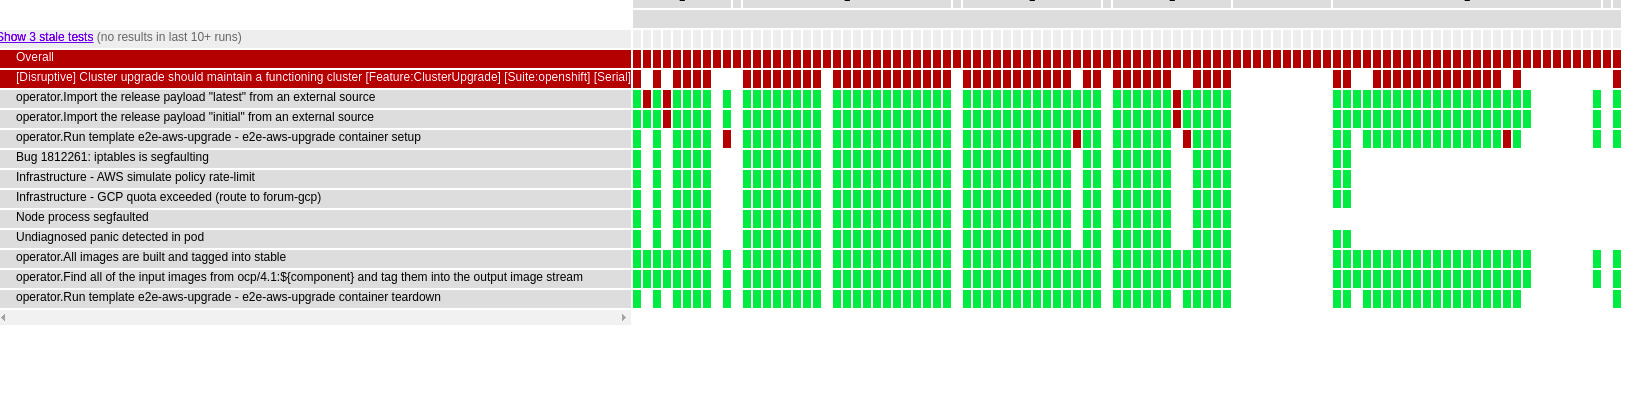

In [3]:
Image(filename="../../../docs/assets/images/testgrid_0.png")

### List all the available dashboards

We need a programmatic way to access all the available Red Hat Dashboards on TestGrid. This can be done by scraping the html of any one of the dashboards. 

In [4]:
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar"
)

In [5]:
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[3]
testgrid_script = testgrid_script.text.split()[5].split(",")
dashboard_names = [x.split(":")[1] for x in testgrid_script if "name" in x]
dashboard_names

['"redhat-assisted-installer"',
 '"redhat-openshift-informing"',
 '"redhat-openshift-ocp-release-4.1-blocking"',
 '"redhat-openshift-ocp-release-4.1-informing"',
 '"redhat-openshift-ocp-release-4.2-blocking"',
 '"redhat-openshift-ocp-release-4.2-informing"',
 '"redhat-openshift-ocp-release-4.3-blocking"',
 '"redhat-openshift-ocp-release-4.3-broken"',
 '"redhat-openshift-ocp-release-4.3-informing"',
 '"redhat-openshift-ocp-release-4.4-blocking"',
 '"redhat-openshift-ocp-release-4.4-broken"',
 '"redhat-openshift-ocp-release-4.4-informing"',
 '"redhat-openshift-ocp-release-4.5-blocking"',
 '"redhat-openshift-ocp-release-4.5-broken"',
 '"redhat-openshift-ocp-release-4.5-informing"',
 '"redhat-openshift-ocp-release-4.6-blocking"',
 '"redhat-openshift-ocp-release-4.6-broken"',
 '"redhat-openshift-ocp-release-4.6-informing"',
 '"redhat-openshift-ocp-release-4.7-blocking"',
 '"redhat-openshift-ocp-release-4.7-broken"',
 '"redhat-openshift-ocp-release-4.7-informing"',
 '"redhat-openshift-ocp-re

### Inspect a specific release summary dashboard

Now that we have a programmatic way of collecting all the dashboard names we can use this later on to collect all the available data provided by TestGrid. For now, let's take a look at a specific dashboard and see what kind of information it's summary holds. 

In [6]:
dashboard = "redhat-openshift-ocp-release-4.2-informing"

In [7]:
response = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")

In [8]:
data = response.json()

In [9]:
ocp42 = pd.DataFrame(data)
ocp42

,periodic-ci-openshift-release-master-ci-4.2-e2e-aws-sdn-multitenant,periodic-ci-openshift-release-master-ci-4.2-e2e-gcp,periodic-ci-openshift-release-master-nightly-4.2-console-aws,periodic-ci-openshift-release-master-nightly-4.2-e2e-aws-fips,periodic-ci-openshift-release-master-nightly-4.2-e2e-aws-fips-serial,periodic-ci-openshift-release-master-nightly-4.2-e2e-azure-fips,periodic-ci-openshift-release-master-nightly-4.2-e2e-azure-fips-serial,periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp,periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp-fips,periodic-ci-openshift-release-master-nightly-4.2-e2e-gcp-fips-serial,...,release-openshift-ocp-installer-e2e-metal-serial-4.2,release-openshift-origin-installer-e2e-aws-4.2-cnv,release-openshift-origin-installer-e2e-aws-upgrade-4.1-stable-to-4.2-ci,release-openshift-origin-installer-e2e-aws-upgrade-4.2-stable-to-4.2-nightly,release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2,release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.2,release-openshift-origin-installer-e2e-azure-upgrade-4.2,release-openshift-origin-installer-e2e-gcp-serial-4.2,release-openshift-origin-installer-e2e-gcp-upgrade-4.2,release-openshift-origin-installer-old-rhcos-e2e-aws-4.2
alert,,,,,,,,,,,...,,,,,,,,,,
last_run_timestamp,1616083657000,1616110075000,1616083657000,0,0,0,0,1616103846000,0,0,...,1616079999000,1616096344000,1616095854000,1616026306000,1616072850000,1616072851000,1616072851000,1616096343000,1616072851000,1616068837000
last_update_timestamp,1616110355,1616110166,1616110357,1616110053,1616110048,1616110100,1616110104,1616110049,1616110059,1616110098,...,1616110396,1616110376,1616110126,1616109925,1616110551,1616110341,1616110556,1616110371,1616110008,1616110455
latest_green,no recent greens,no recent greens,no recent greens,no recent greens,no recent greens,no recent greens,no recent greens,no recent greens,no recent greens,no recent greens,...,1,1,1,1,no recent greens,1,1,1,1,1
overall_status,FAILING,FAILING,FAILING,,,,,FAILING,,,...,FLAKY,FLAKY,FLAKY,FLAKY,FAILING,PASSING,PASSING,PASSING,FLAKY,FLAKY
overall_status_icon,warning,warning,warning,,,,,warning,,,...,remove_circle_outline,remove_circle_outline,remove_circle_outline,remove_circle_outline,warning,done,done,done,remove_circle_outline,remove_circle_outline
status,0 of 10 (0.0%) recent columns passed (434 of 4...,0 of 9 (0.0%) recent columns passed (414 of 44...,0 of 10 (0.0%) recent columns passed (392 of 4...,no completed results,no completed results,no completed results,no completed results,0 of 10 (0.0%) recent columns passed (445 of 4...,no completed results,no completed results,...,7 of 10 (70.0%) recent columns passed (658 of ...,9 of 10 (90.0%) recent columns passed (311 of ...,9 of 10 (90.0%) recent columns passed (499 of ...,8 of 10 (80.0%) recent columns passed (497 of ...,0 of 10 (0.0%) recent columns passed (322 of 4...,10 of 10 (100.0%) recent columns passed (500 o...,10 of 10 (100.0%) recent columns passed (500 o...,10 of 10 (100.0%) recent columns passed (880 o...,7 of 10 (70.0%) recent columns passed (453 of ...,4 of 10 (40.0%) recent columns passed (3735 of...
tests,[{'display_name': 'Operator results.operator c...,[{'display_name': 'Operator results.operator c...,[{'display_name': 'Operator results.operator c...,[],[],[],[],[{'display_name': 'Operator results.operator c...,[],[],...,[],[],[],[],[{'display_name': 'Operator results.operator c...,[],[],[],[],[]
dashboard_name,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,...,redhat-openshift-ocp-release-4.2-informing,redhat-openshift-ocp-release-4.2-informing,r

For each dashboard there are a number of jobs associated with it. A job refers to a collection of tests that execute together. In the table above, the columns are different jobs in the dashboards (We will use these column names later to get access to the detailed data). And for each job we have a number of features, some which contain additional data. 

* last run
* last update
* latest_green
* overall_status
* overall_status_icon
* status**
* tests**
* dashboard_name
* healthiness**

_** features that have additional data_

Let's take a look at the additional data stored in status and tests for a job.

In [10]:
print(ocp42.columns[-1])
ocp42.loc["status", ocp42.columns[-1]]

release-openshift-origin-installer-old-rhcos-e2e-aws-4.2


'4 of 10 (40.0%) recent columns passed (3735 of 3747 or 99.7% cells)'

Status is a string value constructed by some other underlying data not present in the summary. I believe this outputs states, for the last 10 runs, how many were completely successful and in this case is equivalent to +4,000 individual test passing.    

In [11]:
for e, i in enumerate(ocp42.columns):
    temp = ocp42.loc["tests", ocp42.columns[e]]
    if temp:
        temp = pd.DataFrame(temp)
        break
temp

,display_name,test_name,fail_count,fail_timestamp,pass_timestamp,build_link,build_url_text,build_link_text,failure_message,linked_bugs,fail_test_link
0,Operator results.operator conditions monitoring,Operator results.operator conditions monitoring,39,1614223692000,0,,,,Operator unavailable (null): null,[],Operator results.operator conditions monitoring
1,Overall,Overall,44,1614223692000,0,,,,,[],Overall
2,operator.Run multi-stage test e2e-aws-sdn-mult...,operator.Run multi-stage test e2e-aws-sdn-mult...,42,1614223692000,0,,,,Installing from release registry.build02.ci.op...,[],operator.Run multi-stage test e2e-aws-sdn-mul...


These tests are ones that have been selected as "alerts" to display on the summary page by testgrid for a specific job on the dashboard. Its unclear here what logic is used to raise tests to "alert" status but it's likely the number or percent of failures(?). We also get the number of failures, as well as the time of the first failure and the time of the last time the test passed.  

**Possible features**

If we were limited to the data provided by a summary we could use some of the following things as vector feature to encode a dashboard:

* percent PASSING
* percent FLAKY
* percent FAILING
* percent STALE
* percent of recent columns passed
* percent cells passed
* average number of alerts in "tests"
* average fail_count across all "tests" 
* average seconds between first fail and last pass

However, there is a lot of summarizing going on here and it does not take into account the _grids_ in the TestGrid tool. Let's move on the more detailed data and see what we have access to there. 

## Detailed View

Lets dig into the time series data in the detailed test grids.

To pull the desired json we can follow this syntax: 

`https://testgrid.k8s.io/{dashboard_name}/table?&show-stale-tests=&tab={job_name}`

To pull the desired json also with the graph-duration-metrics we can follow this syntax: 

`https://testgrid.k8s.io/{dashboard_name}/table?&show-stale-tests=&tab={job_name}&graph-metrics=test-duration-minutes`

From the work above we know how to get the list of all the dashboards and associated jobs. Here we will get the data for the job "release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2" as an example.

In [12]:
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-ocp-release-4.2-informing/table? \
    &show-stale-tests=&tab=release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2&graph-metrics=test-duration-minutes"  # noqa
)

The first thing we want to do is see what what keys we have in our detailed job data. Below we can see that there are a number of fields in this json, but the one we are going to focus on for now is "tests" as it contains the information we need to recreate the testgrids as dataframes or arrays.

In [13]:
for i in response.json().keys():
    print(i)

test-group-name
query
status
phase-timer
cached
summary
bugs
changelists
column_ids
custom-columns
column-header-names
groups
metrics
tests
row_ids
timestamps
clusters
test_id_map
test-metadata
stale-test-threshold
num-stale-tests
add-tabular-names-option
show-tabular-names
description
bug-component
code-search-path
open-test-template
file-bug-template
attach-bug-template
results-url-template
code-search-url-template
about-dashboard-url
open-bug-template
context-menu-template
results-text
latest-green
triage-enabled
notifications
overall-status


Looking at the complete json output for tests, looks like there are a number of fields that currently aren't populated or have duplicate data, so lets go ahead and drop them. Specifically, "linked_bugs", "message", "short_texts", user_property", "target", and "original-name".   

In [14]:
details = pd.DataFrame(response.json()["tests"]).drop(
    [
        "linked_bugs",
        "messages",
        "short_texts",
        "user_property",
        "target",
        "original-name",
    ],
    axis=1,
)
details

,name,alert,statuses,graphs
0,Overall,"{'fail-cl': '1', 'fail-count': 21, 'fail-time'...","[{'count': 21, 'value': 12}, {'count': 1, 'val...","[{'metric': ['test-duration-minutes'], 'values..."
1,operator.Run template e2e-aws-upgrade - e2e-aw...,"{'fail-cl': '1', 'fail-count': 19, 'fail-time'...","[{'count': 12, 'value': 12}, {'count': 1, 'val...","[{'metric': ['test-duration-minutes'], 'values..."
2,operator.Run template e2e-aws-upgrade - e2e-aw...,None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values..."
3,operator.Run template e2e-aws-upgrade - e2e-aw...,None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values..."
4,"operator.Import the release payload ""initial"" ...",None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values..."
5,"operator.Import the release payload ""latest"" f...",None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values..."
6,operator.Find all of the input images from ocp...,None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values..."
7,operator.All images are built and tagged into ...,None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values..."
8,Operator results.operator conditions authentic...,"{'fail-cl': '1', 'fail-count': 27, 'fail-time'...","[{'count': 12, 'value': 12}, {'count': 1, 'val...",NaN
9,Operator results.operator conditions cloud-cre...,"{'fail-cl': '1', 'fail-count': 27, 'fail-time'...","[{'count': 12, 'value': 12}, {'count': 1, 'val...",NaN


From the column "statuses" above we can see that the time series data is [run length encoded](https://en.wikipedia.org/wiki/Run-length_encoding). Let's add a decoded column so we can get the data in an array format we could use for machine learning. 

In [15]:
def decode_run_length(x):
    lst = []
    for run_length in x:
        extension = [run_length["value"]] * run_length["count"]
        lst.extend(extension)
    return lst

In [16]:
details["values"] = details["statuses"].apply(decode_run_length)

In [17]:
details

,name,alert,statuses,graphs,values
0,Overall,"{'fail-cl': '1', 'fail-count': 21, 'fail-time'...","[{'count': 21, 'value': 12}, {'count': 1, 'val...","[{'metric': ['test-duration-minutes'], 'values...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
1,operator.Run template e2e-aws-upgrade - e2e-aw...,"{'fail-cl': '1', 'fail-count': 19, 'fail-time'...","[{'count': 12, 'value': 12}, {'count': 1, 'val...","[{'metric': ['test-duration-minutes'], 'values...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
2,operator.Run template e2e-aws-upgrade - e2e-aw...,None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
3,operator.Run template e2e-aws-upgrade - e2e-aw...,None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
4,"operator.Import the release payload ""initial"" ...",None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
5,"operator.Import the release payload ""latest"" f...",None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
6,operator.Find all of the input images from ocp...,None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
7,operator.All images are built and tagged into ...,None,"[{'count': 12, 'value': 1}, {'count': 1, 'valu...","[{'metric': ['test-duration-minutes'], 'values...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, ..."
8,Operator results.operator conditions authentic...,"{'fail-cl': '1', 'fail-count': 27, 'fail-time'...","[{'count': 12, 'value': 12}, {'count': 1, 'val...",NaN,"[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
9,Operator results.operator conditions cloud-cre...,"{'fail-cl': '1', 'fail-count': 27, 'fail-time'...","[{'count': 12, 'value': 12}, {'count': 1, 'val...",NaN,"[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."


Now that we have all our data unrolled, lets plot it and confirm it matches the testgrid images displayed on the website. 

_note: these did match at 12:23  pm 11/19/2020 if they no longer appear to, the image needs update. Live rendering of the grid can be found here https://testgrid.k8s.io/redhat-openshift-ocp-release-4.2-informing#release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.1-to-4.2_

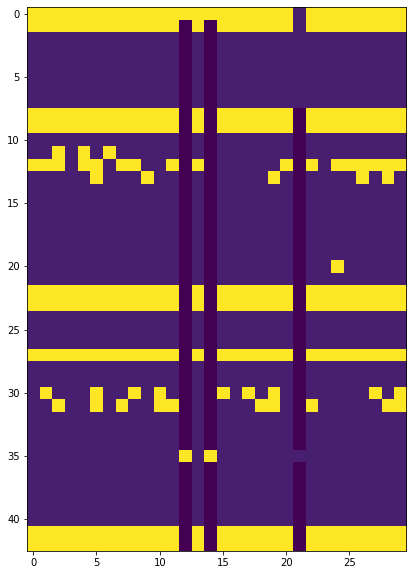

In [18]:
plt.figure(figsize=(20, 10))
plt.imshow(np.array(list(details["values"].values)))
plt.show()

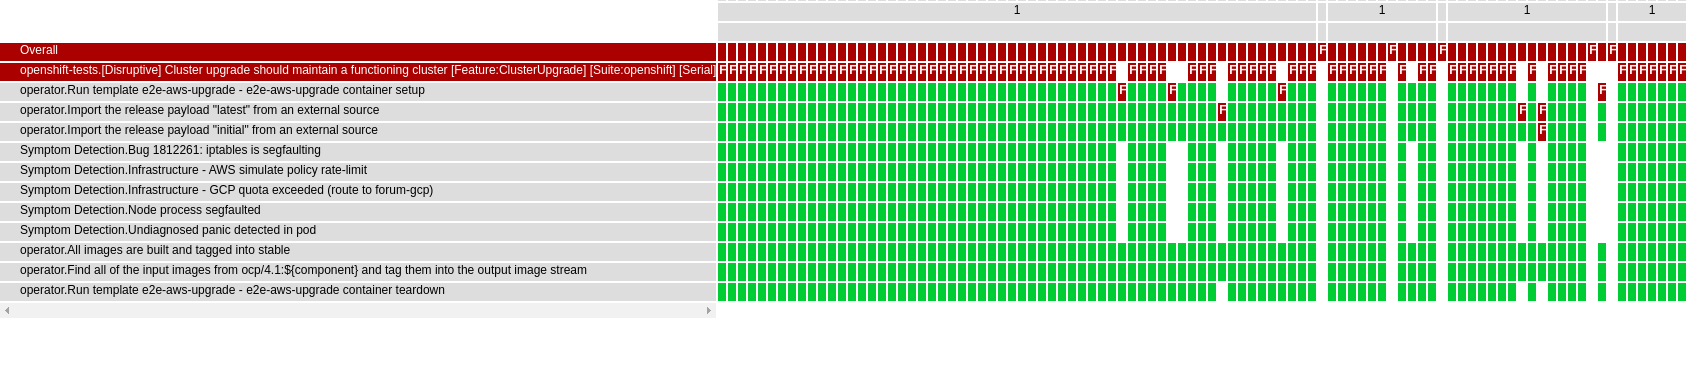

In [19]:
Image(filename="../../../docs/assets/images/testgrid_01.png")

Excellent. As we can see from the images above, we now have a means of going from any testgrid dashboard of interest directly to a 2d numpy representation of our grids where we could apply some 2D signal processing, computer vision or even convolutional neural network methods (maybe). Maybe we could even consider collecting a number of these objects over multiple days and treat it as a 3D tensor of 2D frames? These are just some possible ideas, but the main point here is that we now have the  testgrid data represented in a more data science friendly format, opening many more possible avenues for analysis.      

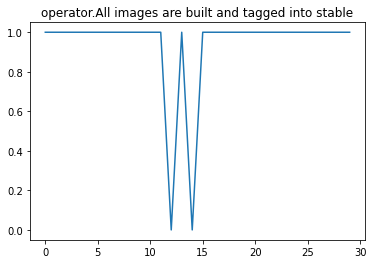

In [20]:
plt.plot(details["values"][7])
plt.title(details["name"][7])
plt.show()

We can also break our data down to a single time series, if we want to directly analyze the behavior of a single test within this job. 

Let's look into the time duration for each test within a Job. There are inbuilt Graphs within TestGrid for each Test in the job, which capture the time taken for running each test.

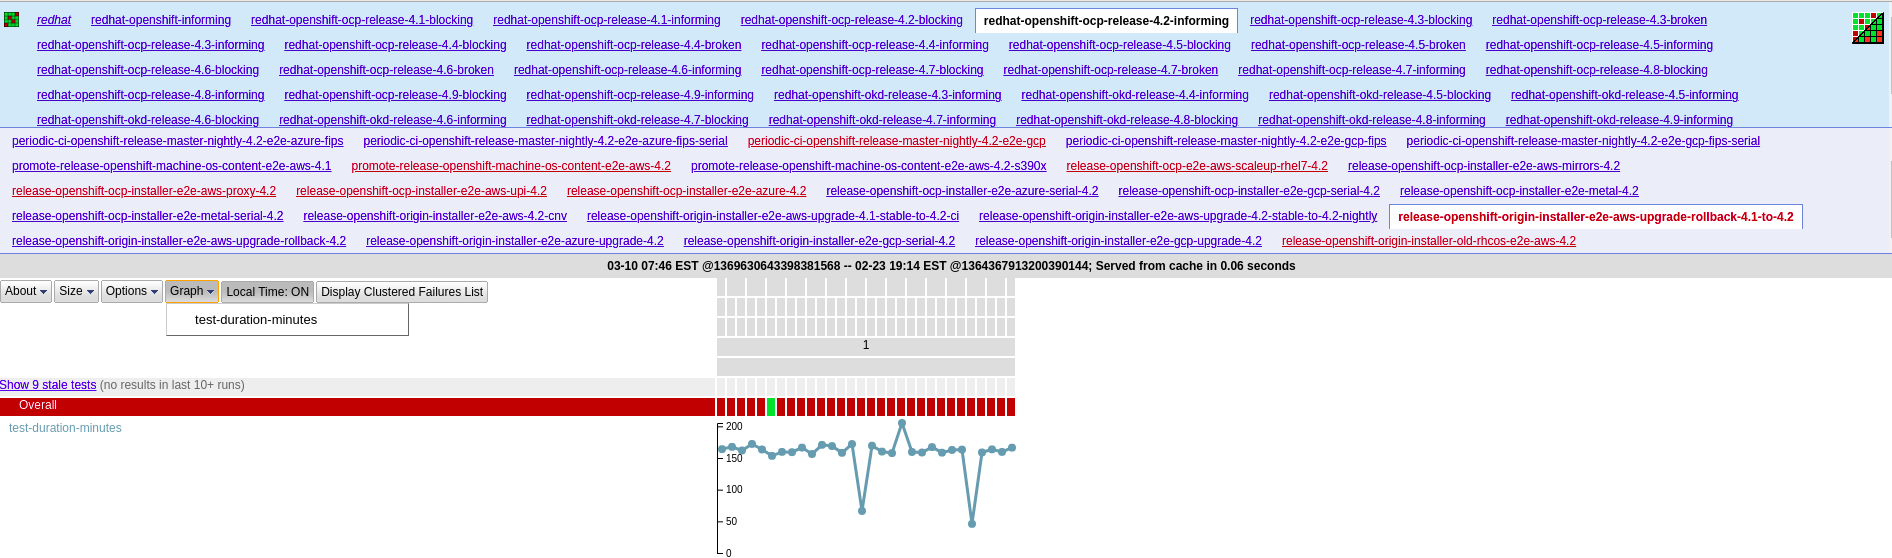

In [21]:
Image(filename="../../../docs/assets/images/time_duration_01.png")

The time elapsed for the test (which is denoted by the metric test-duration-minutes) is plotted over time and it captures values such as `24.76` minutes, which is the time that it took to run the test `operator.Run template e2e-aws-upgrade - e2e-aws-upgrade container setup` under a particular build ID (`1369630643398381568`) at a given timestamp.

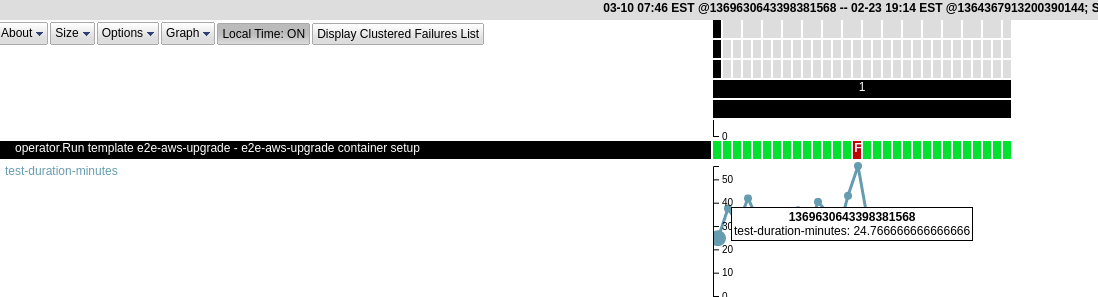

In [22]:
Image(filename="../../../docs/assets/images/time_duration_02.png")

In [23]:
details = details[["name", "graphs"]]

In [24]:
details.head()

,name,graphs
0,Overall,"[{'metric': ['test-duration-minutes'], 'values..."
1,operator.Run template e2e-aws-upgrade - e2e-aw...,"[{'metric': ['test-duration-minutes'], 'values..."
2,operator.Run template e2e-aws-upgrade - e2e-aw...,"[{'metric': ['test-duration-minutes'], 'values..."
3,operator.Run template e2e-aws-upgrade - e2e-aw...,"[{'metric': ['test-duration-minutes'], 'values..."
4,"operator.Import the release payload ""initial"" ...","[{'metric': ['test-duration-minutes'], 'values..."


The `graphs` field is a list for each test within a job which consists of time taken in minutes for running that particular test over multiple timestamps and the "Overall" is an aggregate of time taken for the individual tests for that particular build.

In [25]:
details.graphs[0]

[{'metric': ['test-duration-minutes'],
  'values': [[164.96666666666667,
    163.25,
    167.65,
    162.45,
    161.01666666666668,
    164.28333333333333,
    157.88333333333333,
    163.56666666666666,
    169.43333333333334,
    163.46666666666667,
    167.86666666666667,
    160.71666666666667,
    84.75,
    168.33333333333334,
    14.4,
    166.95,
    163.96666666666667,
    167.55,
    161.83333333333334,
    172.18333333333334,
    163.45,
    153.35,
    159.58333333333334,
    159.13333333333333,
    166.43333333333334,
    156.26666666666668,
    170.73333333333332,
    168.81666666666666,
    158.1,
    172.05]]}]

## Download Data

Now that we have a fairly clear view of the data available to us via TestGrid and how to get it into a data science friendly format, the next thing we want to do is collect a large sample of this data and see how we can organize it in aggregate (across jobs). As this data appears to update at least daily, we also want to pull a large sample, so that we have a fixed data set to work with moving forward (one that is immutable (doesn't change on us every day), and available independent of the TestGrid service's availability).   

We will now go ahead and download the grid data similar to what is represented above in the data frame "details" for each job: 

In [26]:
download = True
if download:
    data_set = {}

    for dashboard in dashboard_names:
        response_1 = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")
        jobs = response_1.json().keys()
        dashboard_jobs = {}

        for job in jobs:
            response_2 = requests.get(
                f"https://testgrid.k8s.io/{dashboard}/table?&show-stale-tests=&tab={job}&graph-metrics=test-duration-minutes"  # noqa
            )
            if response_2.status_code != 200:
                continue

            if "tests" in response_2.json():
                grid = []
                for x in response_2.json()["tests"]:
                    test = {"name": x["name"], "statuses": x["statuses"]}
                    if "graphs" in x.keys():
                        test["graphs"] = x["graphs"]
                    else:
                        test["graphs"] = None
                    grid.append(test)

                time_stamps = response_2.json()["timestamps"]

                dashboard_jobs[job] = {"grid": grid, "timestamps": time_stamps}

        data_set[dashboard] = dashboard_jobs
        print(f"{dashboard} downloaded ")
else:
    print("Not Downloading")

"redhat-assisted-installer" downloaded 
"redhat-openshift-informing" downloaded 
"redhat-openshift-ocp-release-4.1-blocking" downloaded 
"redhat-openshift-ocp-release-4.1-informing" downloaded 
"redhat-openshift-ocp-release-4.2-blocking" downloaded 
"redhat-openshift-ocp-release-4.2-informing" downloaded 
"redhat-openshift-ocp-release-4.3-blocking" downloaded 
"redhat-openshift-ocp-release-4.3-broken" downloaded 
"redhat-openshift-ocp-release-4.3-informing" downloaded 
"redhat-openshift-ocp-release-4.4-blocking" downloaded 
"redhat-openshift-ocp-release-4.4-broken" downloaded 
"redhat-openshift-ocp-release-4.4-informing" downloaded 
"redhat-openshift-ocp-release-4.5-blocking" downloaded 
"redhat-openshift-ocp-release-4.5-broken" downloaded 
"redhat-openshift-ocp-release-4.5-informing" downloaded 
"redhat-openshift-ocp-release-4.6-blocking" downloaded 
"redhat-openshift-ocp-release-4.6-broken" downloaded 
"redhat-openshift-ocp-release-4.6-informing" downloaded 
"redhat-openshift-ocp-rel

In [31]:
date = datetime.datetime.today()
file_path = f"../../../data/raw/testgrid_{date.day}{date.month}.json"

In [32]:
with open(file_path, "w") as outfile:
    json.dump(data_set, outfile)

We now have our data collected in a dictionary and saved as a json file. And getting the specific test grid is as simple as referencing the dashboard and job of interest:  `data["dashboard_name]["job_name]`

Also, it appears that all the existing test grids taken together is only about 130 Mb, so we should be able to work with the whole set at once without too much trouble.  

# Next Steps:

Now that we know what data we have access to, how to access it and how to collect the entire available dataset, we want to see how to work with the downloaded dataset and see how comparable each of the jobs and tests are. And like most initial data exploration, we're now left with a few more questions then we had at the beginning.   

**What  are some of the questions we are still left with?**

* How comparable are the testgrids?
* How do we analyze them in aggregate to learn from their combined behavior?  
* How many/ which tests do they all have in common?
* Are their time series dates comparable? 
* Are there sub-groups that should only be compared with one another?
* Is looking at the grid matrices independent of test names a valid approach for issue identification? 
* What is the expected behavior of a test over time across multiple jobs.
* How does the entire test platform/specific tests perform on a given day?
* How does the entire test platform behavior evolve over time. 
* Is there sufficient data here for useful ML approaches?
* Can we develop some meaningful alerting/ problem identification with the results of the above questions? 

I think there are enough additional questions here that its growing beyond the scope of this notebook. Let's go ahead address these more complex data set questions in the next [EDA notebook](testgrid_indepth_EDA.ipynb). 